Model taken from here
https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing#scrollTo=F1op-CbyLuN4

In [2]:
import pkasolver as ps
from pkasolver import util
from pkasolver import analysis
import pandas as pd
import numpy as np
from torch_geometric.data import Data
import torch

from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges

pKa marvin_pKa marvin_atom marvin_pKa_type original_dataset       ID  \
0  6.21       6.09          10           basic     ['chembl25']  1702768   
1  7.46        8.2           9           basic     ['chembl25']   273537   
2   4.2       3.94           9           basic  ['datawarrior']     7175   
3  3.73       5.91           8          acidic  ['datawarrior']      998   
4  11.0       8.94          13           basic     ['chembl25']   560562   

                                  smiles  \
0     Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1   
1      Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1   
2                 Brc1cc2cccnc2c2ncccc12   
3                Brc1ccc(-c2nn[n-]n2)cc1   
4  Brc1ccc(Br)c(N(CC2CC2)C2=[NH+]CCN2)c1   

                                          protonated  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                        deprotonated            ka  
0  <img data-content="rdkit/molecule" src="data:i...  6.165950e-07  
1  <img data-content="rdkit/molecule" src="data:i...  3.467369e-08  
2  <img data-content="rdkit/molecule" src="data:i...  6.309573e-05  
3  <img data-content="rdkit/molecule" src="data:i...  1.862087e-04  
4  <img data-content="rdkit/molecule" src="data:i...  1.000000e-11
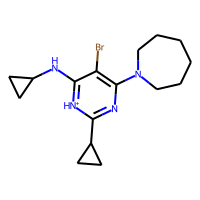
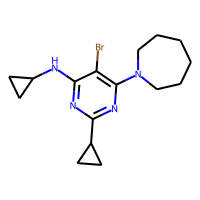
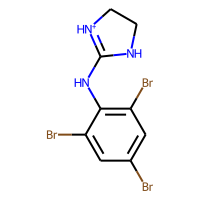
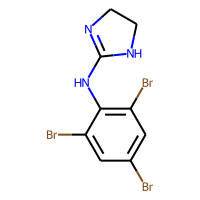
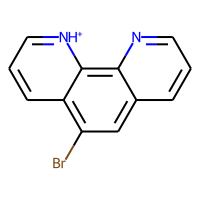
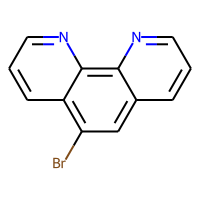
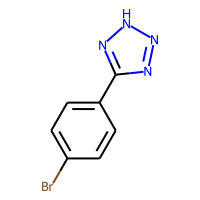
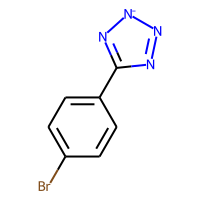
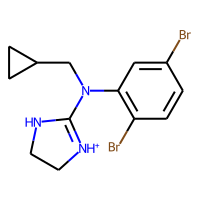
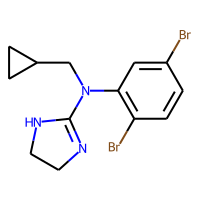

In [3]:
data_folder_Bal = "../data/Baltruschat/"
SDFfile1 = data_folder_Bal + "combined_training_datasets_unique.sdf"
SDFfile2 = data_folder_Bal + "novartis_cleaned_mono_unique_notraindata.sdf"
SDFfile3 = data_folder_Bal + "AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf"

df1 = ps.util.import_sdf(SDFfile1)
df2 = ps.util.import_sdf(SDFfile2)
df3 = ps.util.import_sdf(SDFfile3)

#Data corrections:
df1.marvin_atom[90] = "3"

df1 = util.conjugates_to_DataFrame(df1)
df1 = util.sort_conjugates(df1)
df1 = util.pka_to_ka(df1)
df1.head()

In [4]:
def mol_to_pyg(prot):
#def mol_to_pyg(prot, deprot):    
    """Take protonated molecules and return a Pytorch Geometric Data object."""
    i = 0
    num_atoms = prot.GetNumAtoms()
    nodes = []
    edges = []
    edges_attr = []

    for mol in [prot]:
    #for mol in [prot, deprot]:

        ComputeGasteigerCharges(mol)

        for atom in mol.GetAtoms():
            nodes.append(
                list(
                    (
                        #atom.GetIdx() + num_atoms * i,
                        #float(atom.GetProp("_GasteigerCharge")),
                        atom.GetSymbol() == "C",
                        atom.GetSymbol() == "O",
                        atom.GetSymbol() == "N",
                        atom.GetSymbol() == "P",
                        atom.GetSymbol() == "F",
                        atom.GetSymbol() == "Cl",
                        atom.GetSymbol() == "I",
                        atom.GetFormalCharge(),
                        atom.GetChiralTag(),
                        atom.GetHybridization(),
                        atom.GetNumExplicitHs(),
                        atom.GetIsAromatic(),
                        atom.GetTotalValence(),
                        atom.GetTotalDegree()
                    )
                )
            )

        for bond in mol.GetBonds():
            edges.append(
                np.array(
                    [
                        [bond.GetBeginAtomIdx() + num_atoms * i],
                        [bond.GetEndAtomIdx() + num_atoms * i],
                    ]
                )
            )
            edges.append(
                np.array(
                    [
                        [bond.GetEndAtomIdx() + num_atoms * i],
                        [bond.GetBeginAtomIdx() + num_atoms * i],
                    ]
                )
            )
            bond_type = [bond.GetBondTypeAsDouble(), bond.GetIsConjugated()]
            edges_attr.append(bond_type)
            edges_attr.append(bond_type)

        i += 1

    X = torch.tensor(np.array([np.array(xi) for xi in nodes]), dtype=torch.float)
    edge_index = torch.tensor(np.hstack(np.array(edges)), dtype=torch.long)
#     edge_attr = torch.tensor(np.array(edges_attr).reshape(-1, 1), dtype=torch.float)
    edge_attr = torch.tensor(np.array(edges_attr), dtype=torch.float)

    return Data(x=X, edge_index=edge_index, edge_attr=edge_attr)

In [5]:
#create pyG Dataset
dataset = []
for i in range(len(df1.index)):
    dataset.append(mol_to_pyg(df1.protonated[i]))
    #dataset.append(mol_to_pyg(df1.protonated[i],df1.deprotonated[i]))
    dataset[i].y = torch.tensor([float(df1.pKa[i])], dtype=torch.float32)

print(dataset[0], '\n\n' ,dataset[0].x,'\n\n', dataset[0].edge_index,'\n\n', dataset[0].edge_attr)
# print(dataset[0].x, dataset[0].edge_attr)

Data(edge_attr=[48, 2], edge_index=[2, 48], x=[21, 14], y=[1]) 

 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 1., 1., 4., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 3., 2.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1

In [6]:
n=3
print(dataset[n].edge_attr.size(-1),
dataset[n].x.size(-1))

2 14


In [7]:
#set Hyperparameters
train_test_split = 0.8
#hidden_channels = 32
learning_rate = 0.001
batch_size = 64
num_epochs = 200

In [8]:
#split train and test set
import random

#random.shuffle(dataset)

split_length=int(len(dataset)*train_test_split)
train_dataset = dataset[:split_length]
test_dataset = dataset[split_length:]

In [9]:
#create Dataloader objects that contain batches 
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

In [18]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
criterion = torch.nn.MSELoss()
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

from torch_geometric.nn import global_add_pool, GCNConv, global_max_pool, NNConv, GENConv

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset[0].num_features
        num_edge_features = dataset[0].num_edge_features
        self.dim = dim
        
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, num_features* dim))
        self.conv1 = NNConv(num_features, dim, nn=nn)
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, dim* dim))
        self.conv2 = NNConv(dim, dim, nn=nn)
#        self.conv3 = NNConv(dim, dim, nn=nn)
#         self.conv4 = NNConv(dim, dim, nn=nn)
#         self.conv5 = NNConv(dim, dim, nn=nn)
#         self.conv6 = NNConv(dim, dim, nn=nn)


        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, 1)

    def forward(self, x, edge_index, batch, edge_attr):
        #edge_index = edge_index.view(2, -1)
        #edge_attr = edge_attr.view(-1)
        
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
#        x = F.relu(self.conv3(x, edge_index, edge_attr))
#         x = F.relu(self.conv4(x, edge_index, edge_attr))
#         x = F.relu(self.conv5(x, edge_index, edge_attr))
#         x = F.relu(self.conv6(x, edge_index, edge_attr))
        x = global_max_pool(x, batch)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return x

In [19]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu') # Because if torch.device=cuda --> RuntimeError: CUDA error: out of memory

model = Net(dim=96).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Net(
  (conv1): NNConv(14, 96)
  (conv2): NNConv(96, 96)
  (fc1): Linear(in_features=96, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=1, bias=True)
)


#### Fitting the whole Training and Test set

In [20]:
def train(loader):
    model.train()
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch, data.edge_attr).flatten()
        #print(output.shape,data.y.shape)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
    return loss

def test(loader):
    model.eval()
    loss = torch.Tensor([0]).to(device=device)
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.edge_attr).flatten()
        loss += criterion(out, data.y)
    return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches



In [21]:
for epoch in range(1, num_epochs+1):
    train_loss = train(train_loader)
    train_acc = test(train_loader).item()
    test_acc = test(test_loader).item()
    print(f'Epoch: {epoch:03d}, Train MSE: {train_acc:.4f}, Test MSE: {test_acc:.4f}')

Epoch: 001, Train MSE: 5.2758, Test MSE: 5.8230
Epoch: 002, Train MSE: 3.7101, Test MSE: 3.9365
Epoch: 003, Train MSE: 3.0702, Test MSE: 3.3870
Epoch: 004, Train MSE: 3.3428, Test MSE: 3.7171
Epoch: 005, Train MSE: 2.5469, Test MSE: 3.0411
Epoch: 006, Train MSE: 2.1293, Test MSE: 2.3508
Epoch: 007, Train MSE: 2.2906, Test MSE: 2.3760
Epoch: 008, Train MSE: 1.9617, Test MSE: 2.2442
Epoch: 009, Train MSE: 1.7108, Test MSE: 2.0894
Epoch: 010, Train MSE: 1.5810, Test MSE: 2.0782
Epoch: 011, Train MSE: 1.8691, Test MSE: 2.4895
Epoch: 012, Train MSE: 1.6589, Test MSE: 2.2473
Epoch: 013, Train MSE: 1.5530, Test MSE: 1.9708
Epoch: 014, Train MSE: 1.5160, Test MSE: 2.0126
Epoch: 015, Train MSE: 1.3513, Test MSE: 1.8414
Epoch: 016, Train MSE: 1.4636, Test MSE: 1.8870
Epoch: 017, Train MSE: 1.2248, Test MSE: 1.8849
Epoch: 018, Train MSE: 1.3178, Test MSE: 1.9098
Epoch: 019, Train MSE: 1.2760, Test MSE: 1.9339
Epoch: 020, Train MSE: 1.4928, Test MSE: 1.9574
Epoch: 021, Train MSE: 1.1864, Test MSE:

#### Overfitting on one Batch

In [ ]:
print(data.x)

In [ ]:
def train(data):
    model.train()

#    if epoch == 51:
#        for param_group in optimizer.param_groups:
#            param_group['lr'] = 0.5 * param_group['lr']
    
    data = data.to(device)
    optimizer.zero_grad()
    output = model(data.x, data.edge_index, data.batch, edge_weight = data.edge_attr).flatten()
    #print(output.shape,data.y.shape)
    loss = criterion(output, data.y)
    
    loss.backward()
    optimizer.step()
    return loss

def test(data):
    model.eval()
    
    data = data.to(device)
    out = model(data.x, data.edge_index, data.batch, edge_weight = data.edge_attr).flatten()
    loss = criterion(out, data.y)
    return loss

In [ ]:
data = next(iter(train_loader))

for epoch in range(1, 2001):
    train_loss = train(data)
    test_loss = test(data)
    print(f'Epoch: {epoch:03d}, Train MSE: {train_loss:.4f}, Test MSE: {test_loss:.4f}')